## Final Project for 5632

  Our goal for this project will be CUSTOMER SEGMENTATION using an unsupervised learning approach. let's start off by
  importing our libraries and data.

### Gather Data

In [59]:
#first we need to import all our libraries
import pandas as pd
import numpy as np
from google.colab import files
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN


In [28]:
#lets start by uploading and loading our data
#uploaded = files.upload()
df = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')

###Identifing an Unsupervised Learning Problem
our goal this project is going to be customer segmentation utilizing RFM (recency frequency monetary) data derived from out dataset. We will achieve our goal utilizing a K-Means approach. We will then illustrate how in a real world setting, this data could be used to best group a customer base and focus on retaining or improving marketing geared towards certain customer bases.

###EDA (Exploratory Data Analysis):
We're going to start off by exploring our data and getting a sense of the size and using different graphs to visualize our data.

We will also clean our data as needed to best support our model.

In [29]:
#lets preview our data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [30]:
#check our data for it's types and any missing values
df.info()

#lets take note of how many unique customers and invoices we have
print(f"Unique Customers: {df['CustomerID'].nunique()}")
print(f"Unique Invoices: {df['InvoiceNo'].nunique()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
Unique Customers: 4372
Unique Invoices: 25900


In [31]:
df.shape

(541909, 8)

In [32]:
#count our missing values per column
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


Looks like we have some null values in description and customerID we will need to handle

In [33]:
#drop our null valaues
df = df.dropna(subset=['CustomerID', 'Description'])

#convert our data types
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

#remove any canceled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

#remove any negative or zero quantity
df = df[df['Quantity'] > 0]

#remove any negative or zero price entries
df = df[df['UnitPrice'] > 0]

#create a 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


<ipython-input-33-aaad3c99a57c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)


## Analysis using an Unsupervised Model (K Means):

Next we will create our RFM Table (Recency, Frequency, Monetary)

In [35]:
#we will use a reference date for Recency
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)

#aggregate our data
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

#next we will rename our columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


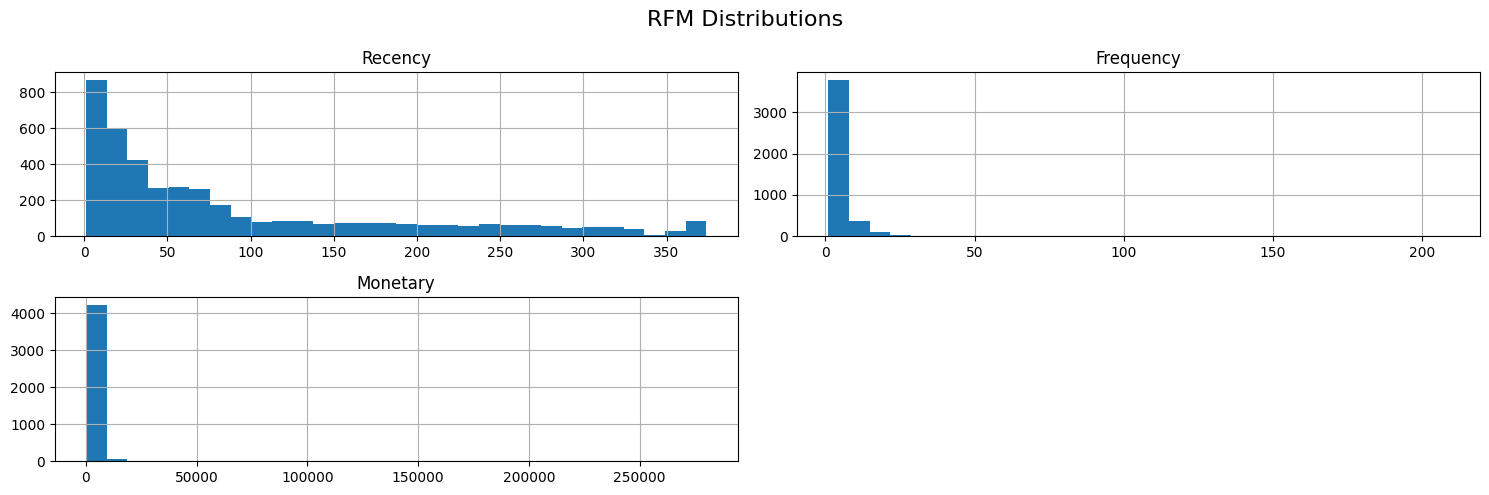

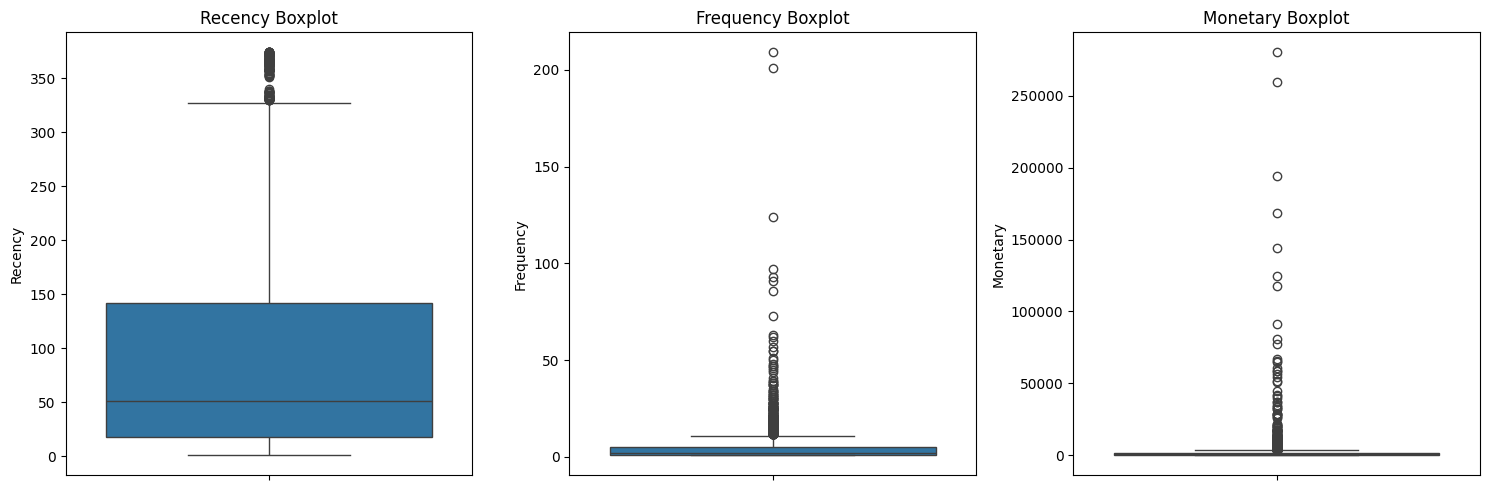

In [37]:
#lets visualize our RFM!
rfm.hist(bins=30, figsize=(15, 5))
plt.suptitle("RFM Distributions", fontsize=16)
plt.tight_layout()
plt.show()

#lets make some boxplots
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Recency', 'Frequency', 'Monetary']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=rfm[col])
    plt.title(f"{col} Boxplot")
plt.tight_layout()
plt.show()

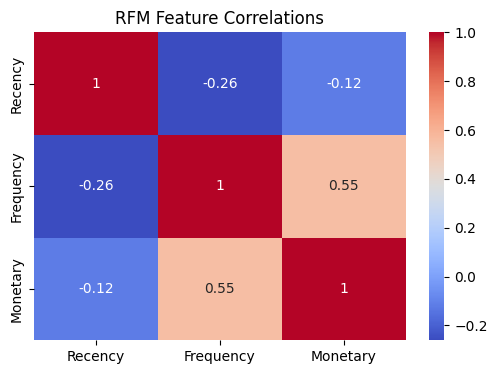

In [38]:
#lets make a correlation matrix
plt.figure(figsize=(6,4))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm')
plt.title("RFM Feature Correlations")
plt.show()

In [40]:
#lets scale our RFM so no data overpowers the others and we can have proper ratios
#initialize and fit the scaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

#convert back to DataFrame for readability
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)

rfm_scaled.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346,2.334574,-0.425097,8.358668
12347,-0.905340,0.354417,0.250966
12348,-0.175360,-0.035340,-0.028596
12349,-0.735345,-0.425097,-0.033012
12350,2.174578,-0.425097,-0.191347


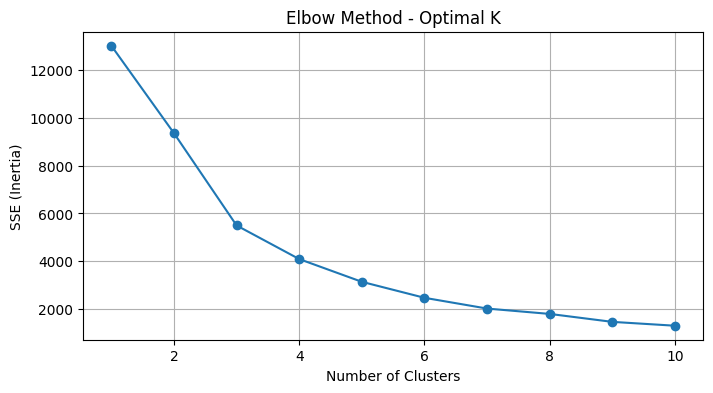

In [44]:
#lets determine the preferred number of clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#we will try K from 1 to 20
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

#plot!
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE (Inertia)")
plt.grid(True)
plt.show()


In [45]:
#looking for the "elbow" we see very clearly that K=4 will be optimal
#fit our KMeans with K=4
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

#preview with our clusters
rfm.head()


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346,326,1,77183.60,3
12347,2,7,4310.00,0
12348,75,4,1797.24,0
12349,19,1,1757.55,0
12350,310,1,334.40,1


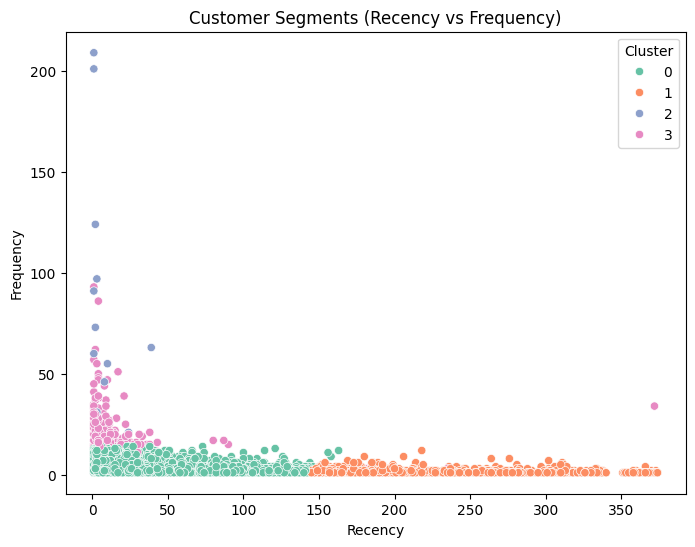

In [46]:
#lets start visualizing some of our clusters
#recency vs frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Recency', y='Frequency', hue='Cluster', palette='Set2')
plt.title("Customer Segments (Recency vs Frequency)")
plt.show()


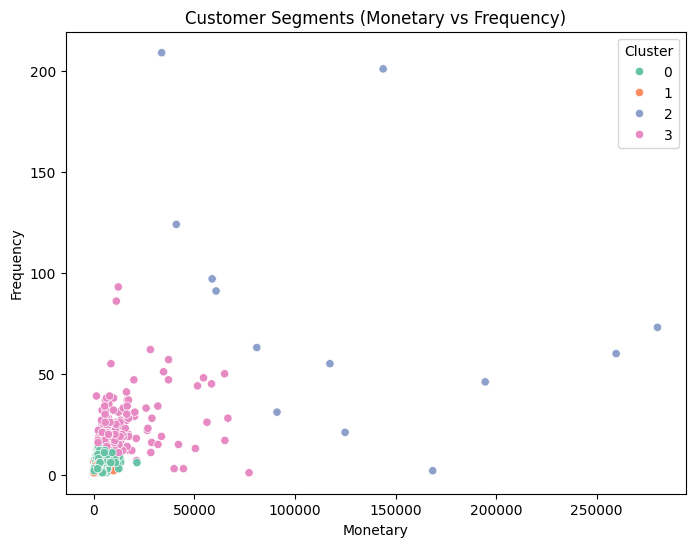

In [51]:
#monetary vs frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Monetary', y='Frequency', hue='Cluster', palette='Set2')
plt.title("Customer Segments (Monetary vs Frequency)")
plt.show()


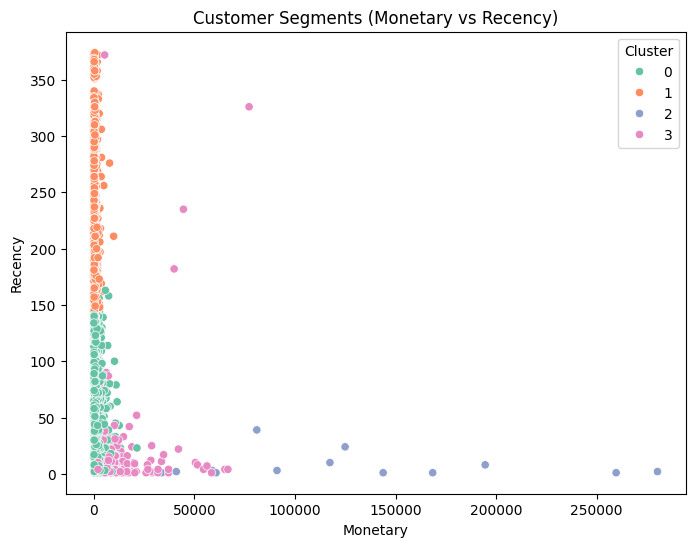

In [52]:
#monetary vs recency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Monetary', y='Recency', hue='Cluster', palette='Set2')
plt.title("Customer Segments (Monetary vs Recency)")
plt.show()


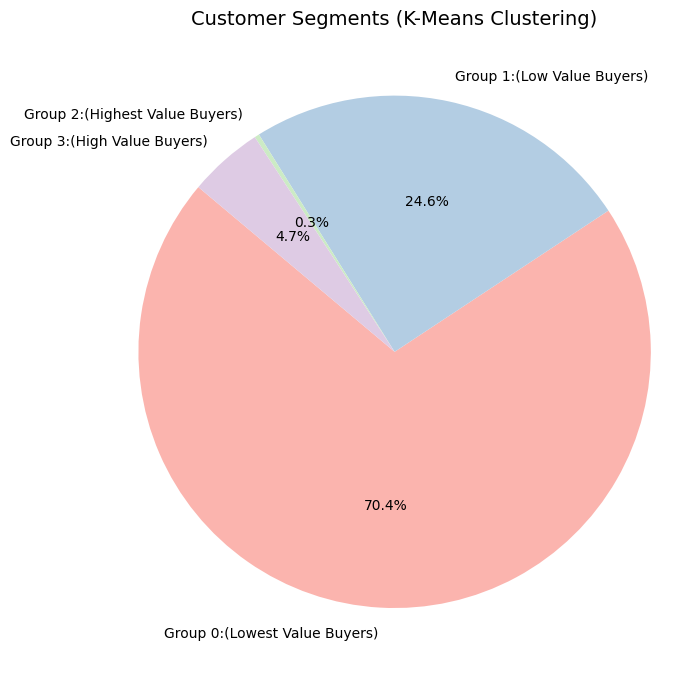

In [58]:
#finish of with a pi graph illustrating distrubution of our customer base
cluster_labels = {
    0: "Group 0:(Lowest Value Buyers)",
    1: "Group 1:(Low Value Buyers)",
    2: "Group 2:(Highest Value Buyers)",
    3: "Group 3:(High Value Buyers)"
}

kmeans_counts = rfm['Cluster'].value_counts().sort_index()
labels = [cluster_labels[i] for i in kmeans_counts.index]

plt.figure(figsize=(7, 7))
plt.pie(
    kmeans_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10},
    colors=plt.cm.Pastel1.colors
)
plt.title('Customer Segments (K-Means Clustering)', fontsize=14)
plt.axis('equal')
plt.tight_layout()
plt.show()



Alternative Approach for Comparison (DBSCAN)


In [85]:
dbscan = DBSCAN(eps=0.130, min_samples=9)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)

#see our cluster labels (-1 is identified as noise)
rfm['DBSCAN_Cluster'].value_counts()

,count
DBSCAN_Cluster,
0,3728
-1,495
1,57
2,43
3,15


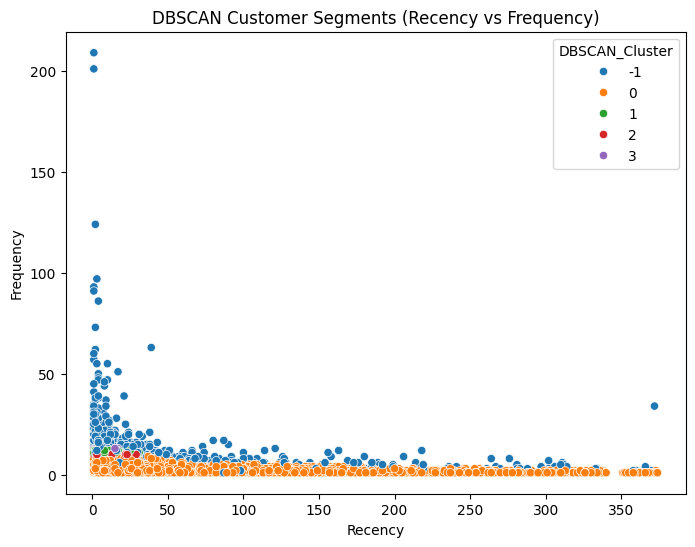

In [86]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm,
    x='Recency', y='Frequency',
    hue='DBSCAN_Cluster',
    palette='tab10',
    legend='full'
)
plt.title("DBSCAN Customer Segments (Recency vs Frequency)")
plt.show()


DBScan approach...
the DBSCAN approach was a bit difficult to fine tune the parameters and after a lot of expirimentation, i could not find a proper parameter that correctly matched the accuracy of our K-MEANS model.
In conculusion the KMEANS method gave us much more favorable results and will remain our preferred model.

##Discussion/Conclusions
Observing our final 3 graphs we can see how our model grouped our customers. utilizing k=4, we now have 4 groups of customers that can be defined as...

Group 0	Low Recency, Low Frequency & Monetary	Recent, (Lowest Value Buyers)
Group 1	High Recency, Low Frequency & Monetary	(Low Value Buyers)
Group 2	Low Recency, High Frequency & Monetary	(Highest Value Buyers)
Group 3	Moderate RFM values	Average Customers (High Value Buyers)

In a real world approach, using this data, you can formulate retention planning amongst your groups 2 and 3 (most valuable) and possibly work to establish better relationships amongst groups 0 and 1 (lowest value) in hopes of gaining loyalty and bringing their metrics closer to that of groups 2 and 3.